# Model Images Clustering
For each product image, select 1 model image, which is closest to a full-body image front-facing.

In [1]:
import os
import glob
from shutil import copyfile
import pandas as pd
import numpy as np
import random

from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import cv2

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.externals import joblib

import sys
sys.path.append("../")
from src import image_utils

%matplotlib inline

# Load images

In [23]:
# read data
filelist = glob.glob('../data/images/fashion_models/dresses/*.jpg')
filelist = sorted(filelist)
print('num images: ', len(filelist))

num images:  63103


# Get Feature Vectors

In [3]:
def get_features(file_list, img_size, feature_fun=None, crop=True, print_progress=False):
    
    if not feature_fun:
        feature_fun = image_utils.get_mask
        
    if not img_size:
        img_size = [256, 256]
    
    features = []
    
    for idx, img_path in enumerate(file_list):
        if (idx % 5000 == 0) & print_progress:
            print(idx)
        
        feature = feature_fun(img_path, img_size, crop)
        features.append(feature)
        
    X = np.array([f for f in features])
    return X

In [56]:
def load_features(feat_file, img_size, feature_fun, crop):
    try:
        features = np.load(feat_file)
    except:
        features = get_features(filelist, img_size, feature_fun, crop)
        os.makedirs(os.path.dirname(feat_file))
        np.save(feat_file, outlines)
        
    return features

In [4]:
img_size = [64, 64]

In [61]:
thresh_path = '../data/clustering/features_threshold.npy'
masks = load_features(thresh_path, img_size, image_utils.get_mask, crop=True)

edges_path = '../data/clustering/features_edges_crop.npy'
edges = load_features(edges_path, img_size, image_utils.get_edges, crop=True)

In [62]:
print(edges.shape)
print(masks.shape)

(63103, 64, 64)
(63103, 64, 64)


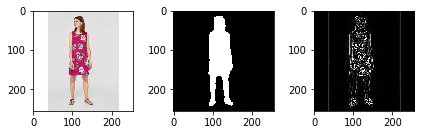

In [63]:
fig, axarr = plt.subplots(1, 3)
axarr[0].imshow(Image.open(filelist[5]))
axarr[1].imshow(image_utils.get_mask(filelist[5], img_size=[256, 256]), cmap='gray')
axarr[2].imshow(image_utils.get_edges(filelist[5], img_size=[256, 256]), cmap='gray')
    
plt.tight_layout()

# Cluster

In [64]:
def load_cluster(features, model_file, n_clusters=3):
    
    try:
        kmeans = joblib.load(model_file)
    except:
        kmeans = KMeans(n_clusters=n_clusters)
        X = features.reshape([features.shape[0], np.prod(features.shape[1:])])
        kmeans.fit(X)
        joblib.dump(kmeans, model_file) 

    clusters = kmeans.labels_.tolist()
    centers = np.array(kmeans.cluster_centers_)
    
    return clusters, centers

In [69]:
thresh_file = '../data/clustering/outlines_3.pkl'
clusters_thresh, centers_thresh = load_cluster(masks, thresh_file)

In [86]:
edges_file = '../data/clustering/edges_crop_3.pkl'
clusters_edges, centers_edges = load_cluster(edges, edges_file, n_clusters=3)

##  Visualize Clusters

In [87]:
def plot_images_by_cluster(df_cluster, num_imgs, cluster_centers):
    
    n_clusters = df_cluster.cluster.nunique()        
    imgs = df_cluster.groupby('cluster').agg({'path': 'unique'})
    random.seed(42)
    
    ncols = num_imgs+1
    fig, axarr = plt.subplots(nrows=n_clusters, ncols=ncols, figsize=(2*num_imgs, 2*n_clusters))
    
    for cluster in imgs.index:
        cluster_imgs = imgs.loc[cluster, 'path'].tolist()
        print('Cluster {}: {} images'.format(cluster, len(cluster_imgs)))
        cluster_imgs = random.sample(cluster_imgs, num_imgs)
        
        plt_idx = 0
        # plot centers
        ax = axarr[cluster][plt_idx]
        ax.axis('off')
        center = np.array(cluster_centers)[cluster]
        img = Image.fromarray(center.reshape(img_size))
        ax.imshow(img)
        plt_idx = 1
        
        for img_path in cluster_imgs:
            ax = axarr[cluster][plt_idx]
            ax.axis('off')
            img = Image.open(img_path)
            ax.imshow(img)
            plt_idx += 1
            
    plt.show()

In [88]:
def plot_cluster_centers(centers):
    
    fig=plt.figure(figsize=(8, 8))
    
    for idx, center in enumerate(centers):
        ax = fig.add_subplot(4, 4, idx+1)
        ax.axis('off')
        center = center.reshape(img_size)
        img = Image.fromarray(center)
        plt.imshow(img)
    plt.show()

In [89]:
# number of images by cluster
df_edges = pd.DataFrame(list(zip(clusters_edges, filelist)), columns=['cluster', 'path'])
df_edges.groupby('cluster').count()

,path
cluster,
0,7315
1,44758
2,11030


In [90]:
df_thresh = pd.DataFrame(list(zip(clusters_thresh, filelist)), columns=['cluster', 'path'])
df_thresh.groupby('cluster').count()

,path
cluster,
0,26832
1,17899
2,18372


## Cluster centers

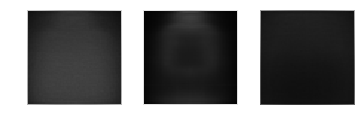

In [91]:
plot_cluster_centers(centers_edges)

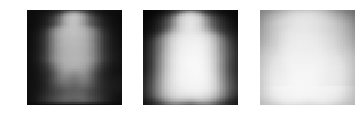

In [92]:
plot_cluster_centers(centers_thresh)

## Plot random sample of images

Cluster 0: 7315 images
Cluster 1: 44758 images
Cluster 2: 11030 images


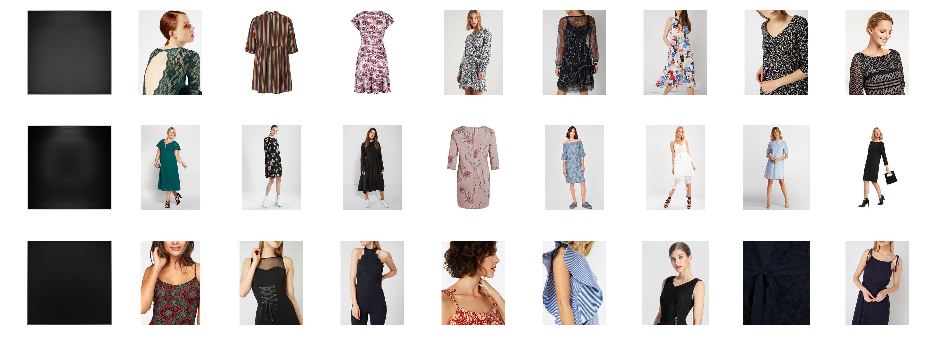

In [93]:
plot_images_by_cluster(df_edges, 8, centers_edges)

Cluster 0: 26832 images
Cluster 1: 17899 images
Cluster 2: 18372 images


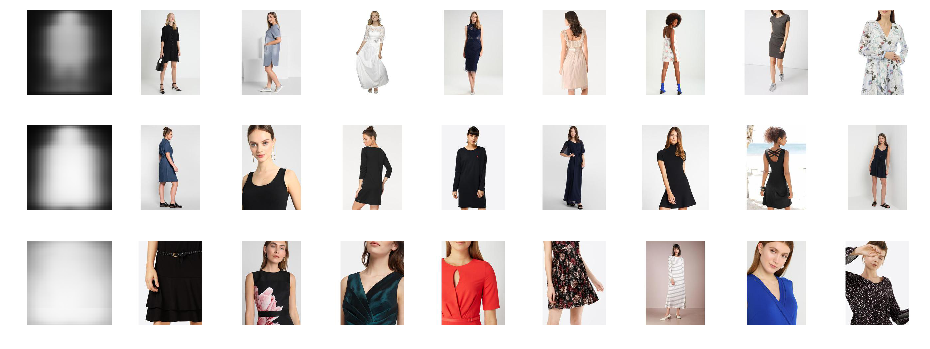

In [94]:
plot_images_by_cluster(df_thresh, 8, centers_thresh)

## Select image for each product

In [95]:
def get_id_from_img_path(img_path):
    return os.path.basename(img_path).split('@')[0]

In [96]:
def get_product_id_file_idxs(product_id, filelist):
    return [idx for idx, f in enumerate(filelist) if get_id_from_img_path(f) == product_id]

In [97]:
def get_product_files_and_features(product_id, filelist, features):
    product_idxs = get_product_id_file_idxs(product_id, filelist)
    product_files = np.array(filelist)[product_idxs]
    product_feats = reshape_features(features[product_idxs])
    
    return product_files, product_feats

In [98]:
def reshape_features(features):
    return features.reshape(features.shape[0], np.prod(features.shape[1:]))

In [99]:
def plot_best_images_by_clusters(cluster_centers, product_ids, filelist, features, plot_centers=True):
    n_centers = len(cluster_centers)
    n_products = (len(product_ids) + 1) if plot_centers else len(product_ids)
    
    fig, axarr = plt.subplots(nrows=n_centers, ncols=n_products,
                              figsize=((n_products)*2, (n_centers)*2))
    
    if plot_centers:
        for cen_idx, center in enumerate(cluster_centers):
            ax = axarr[cen_idx][0]
            ax.imshow(Image.fromarray(center.reshape([64, 64])).resize([216, 256]))
            ax.axis('off')
    
    for idx, product_id in enumerate(product_ids):
        product_files, product_feats = get_product_files_and_features(product_id, filelist, features)
    
        dist = pairwise_distances(product_feats, cluster_centers)
        imgs_idxs = dist.argmin(0)
        best_imgs = product_files[imgs_idxs]
        
        for img_idx, img in enumerate(best_imgs):
            ax = axarr[img_idx][idx+1]
            ax.axis('off')
            ax.imshow(Image.open(img))
    
    plt.tight_layout()
    plt.show()


In [104]:
def plot_product_imgs(product_id, best_center, features, filelist):
    product_files, product_feats = get_product_files_and_features(product_id, filelist, features)
    
    dist = pairwise_distances(product_feats, best_center.reshape(1, -1))[:, 0]
    sort_args = np.argsort(dist)
    product_files = np.array(product_files)[sort_args]
    dist = np.array(dist)[sort_args]
    
    n_products = len(product_files) + 1
    fig, axarr = plt.subplots(nrows=1, ncols=n_products, figsize=(n_products*2, 2))
    
    ax = axarr[0]
    ax.imshow(Image.fromarray(best_center.reshape([64, 64])).resize([216, 256]))
    ax.axis('off')
    
    for idx, product_file in enumerate(product_files):  
        ax = axarr[idx+1]
        img = Image.open(product_file)
        ax.set_xlabel(round(dist[idx], 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
        for s in ax.spines.keys():
            ax.spines[s].set_visible(False)
        ax.imshow(img)
    
    plt.show()

In [100]:
product_ids = list(set([get_id_from_img_path(f) for f in filelist]))

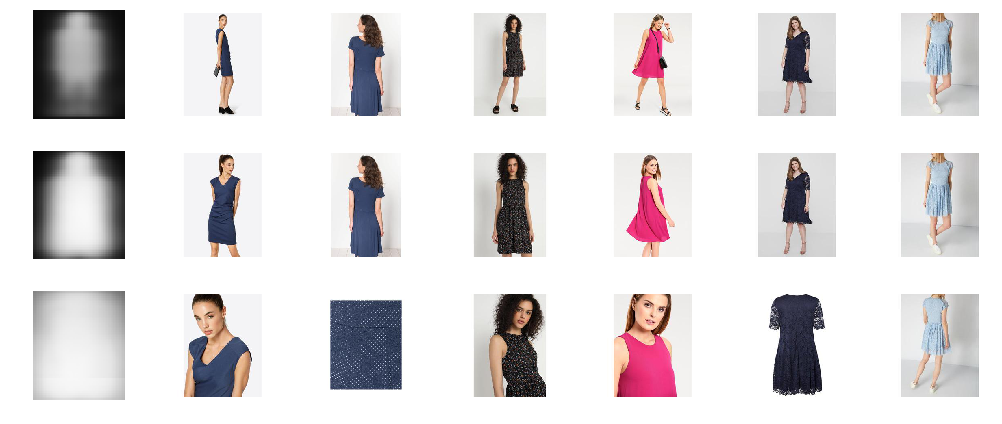

In [102]:
test_ids = [1510, 1511, 1513, 1515, 1512, 1502]

s = np.array(product_ids)[test_ids] 
plot_best_images_by_clusters(centers_thresh, s, filelist, outlines)

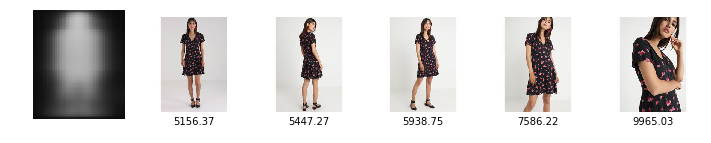

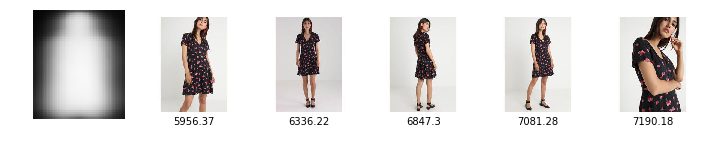

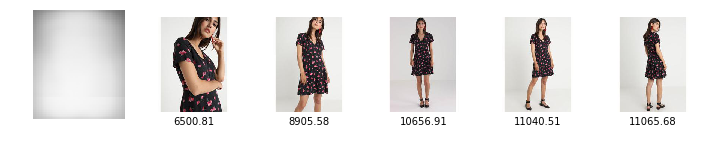

In [105]:
for c in centers_thresh:
    plot_product_imgs(product_ids[8], c, outlines, filelist)

# Save Clustered Images

In [106]:
save_dir = '../data/images/fashion_models/dresses_clustered/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [107]:
def get_best_image_for_cluster(img_features, cluster_center):
    
    img_features = img_features.reshape(img_features.shape[0], 
                                        np.prod(img_features.shape[1:]))
    dist = pairwise_distances(img_features, cluster_center.reshape(1, -1))
    best_img_idx = dist.argmin()
    
    return best_img_idx

In [ ]:
best_cluster_center = centers_thresh[0]

copy = False

for idx, product_id in enumerate(product_ids):
    if idx % 100 == 0:
        print('Clustered: {} / {}'.format(idx, len(product_ids)))

    product_files = [f for f in filelist if get_id_from_img_path(f) == product_id]
    features = get_features(product_files, img_size, image_utils.get_mask, crop=True)
    img_idx = get_best_image_for_cluster(features, best_cluster_center)
    
    src_path = product_files[img_idx]
    dst_path = os.path.join(save_dir, product_id + '.jpg')
    
    if copy:
        copyfile(src_path, dst_path)